In [2]:
import os
os.chdir("..")

In [3]:
!pwd

/Users/timotej/Documents/Projekti/Doktorat/Fine-grained-relations


In [4]:
from data_loaders.i2b2dataLoader import load_absolute_data


/Users/timotej/miniconda3/envs/Fine-grained-relations-3-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
df = load_absolute_data(include_rows_without_absolute=False, use_test_files=True, full_text=True)

In [47]:
df

,text,class,event1_start,event1_end,event2_start,event2_end,event1_id,event2_id,file_id,timexs,additional_document_info,minutes_between_starts,minutes_between_ends,minutes_between_means,event1_text,event2_text,additional_information
0,\nAdmission Date :\n2012-06-07\nDischarge Date...,OVERLAP,387,394,338,343,E10,E8,88,"[{'start': 1261, 'end': 1267, 'val': '2012-06-...","{'times': [('ADMISSION', '2012-06-07'), ('DISC...",2630820.0,2825.0,1316822.5,Inderal,pills,"{'event1_start_time': 56503440.0, 'event2_star..."
1,\nAdmission Date :\n2012-06-07\nDischarge Date...,OVERLAP,399,407,387,394,E11,E10,88,"[{'start': 1261, 'end': 1267, 'val': '2012-06-...","{'times': [('ADMISSION', '2012-06-07'), ('DISC...",9466560.0,5760.0,4736160.0,Klonopin,Inderal,"{'event1_start_time': 47036880.0, 'event2_star..."
2,\nAdmission Date :\n2012-06-07\nDischarge Date...,OVERLAP,460,466,1498,1504,E12,E54,88,"[{'start': 1261, 'end': 1267, 'val': '2012-06-...","{'times': [('ADMISSION', '2012-06-07'), ('DISC...",12097380.0,8585.0,6052982.5,geodon,Geodon,"{'event1_start_time': 47036880.0, 'event2_star..."
3,\nAdmission Date :\n2012-06-07\nDischarge Date...,OVERLAP,460,466,399,407,E12,E11,88,"[{'start': 1261, 'end': 1267, 'val': '2012-06-...","{'times': [('ADMISSION', '2012-06-07'), ('DISC...",0.0,0.0,0.0,geodon,Klonopin,"{'event1_start_time': 47036880.0, 'event2_star..."
4,\nAdmission Date :\n2012-06-07\nDischarge Date...,OVERLAP,399,407,1487,1495,E11,E53,88,"[{'start': 1261, 'end': 1267, 'val': '2012-06-...","{'times': [('ADMISSION', '2012-06-07'), ('DISC...",12097380.0,8585.0,6052982.5,Klonopin,Klonopin,"{'event1_start_time': 47036880.0, 'event2_star..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,\nAdmission Date :\n2019-10-10\nDischarge Date...,BEFORE,1920,1934,1913,1919,E56,E58,392,"[{'start': 1038, 'end': 1048, 'val': '2019-10-...","{'times': [('ADMISSION', '2019-10-10'), ('DISC...",0.0,0.0,0.0,his heart rate,follow,"{'event1_start_time': 63046860.0, 'event2_star..."
3433,\nAdmission Date :\n2019-10-10\nDischarge Date...,OVERLAP,1958,1967,1630,1643,E57,E17,392,"[{'start': 1038, 'end': 1048, 'val': '2019-10-...","{'times': [('ADMISSION', '2019-10-10'), ('DISC...",-50400.0,-38940.0,-44670.0,lopressor,his lopressor,"{'event1_start_time': 63046860.0, 'event2_star..."
3434,\nAdmission Date :\n2019-10-10\nDischarge Date...,BEFORE,1958,1967,1867,1909,E57,E55,392,"[{'start': 1038, 'end': 1048, 'val': '2019-10-...","{'times': [('ADMISSION', '2019-10-10'), ('DISC...",0.0,0.0,0.0,lopressor,the Louis Schubert Community Health Center,"{'event1_start_time': 63046860.0, 'event2_star..."
3435,\nAdmission Date :\n2019-10-10\nDischarge Date...,OVERLAP,295,315,249,256,E1,E27,392,"[{'start': 1038, 'end': 1048, 'val': '2019-10-...","{'times': [('ADMISSION', '2019-10-10'), ('DISC...",0.0,0.0,0.0,loss of consiousness,He fell,"{'event1_start_time': 62994959.0, 'event2_star..."


In [48]:
# Prepare dataset organized by documents with events, locations, and times
import json
import spacy

# Load spacy model for dependency parsing
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Downloading spacy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

def get_token_index(doc, char_pos):
    """Get the token index for a character position"""
    for i, token in enumerate(doc):
        if token.idx <= char_pos < token.idx + len(token.text):
            return i
    return None

def get_syntactic_distance(doc, event_token_idx, timex_token_idx):
    """Calculate syntactic distance between two tokens using dependency tree"""
    if event_token_idx is None or timex_token_idx is None:
        return float('inf')

    event_token = doc[event_token_idx]
    timex_token = doc[timex_token_idx]

    # Get all ancestors for both tokens
    event_ancestors = set([event_token])
    current = event_token
    while current.head != current:
        current = current.head
        event_ancestors.add(current)

    timex_ancestors = set([timex_token])
    current = timex_token
    while current.head != current:
        current = current.head
        timex_ancestors.add(current)

    # Find lowest common ancestor
    common_ancestors = event_ancestors & timex_ancestors
    if not common_ancestors:
        return float('inf')

    # Calculate distance through LCA
    lca = min(common_ancestors, key=lambda t: t.i)

    # Distance from event to LCA
    dist_event = 0
    current = event_token
    while current != lca and current.head != current:
        dist_event += 1
        current = current.head

    # Distance from timex to LCA
    dist_timex = 0
    current = timex_token
    while current != lca and current.head != current:
        dist_timex += 1
        current = current.head

    return dist_event + dist_timex

def find_closest_timex(text, event_start, event_end, timexs):
    """Find the syntactically closest time expression to an event"""
    if not timexs:
        return None

    # Parse the document
    doc = nlp(text)

    # Get token index for event
    event_token_idx = get_token_index(doc, event_start)
    if event_token_idx is None:
        return None

    # Find closest timex by syntactic distance
    min_distance = float('inf')
    closest_timex = None

    for timex in timexs:
        timex_token_idx = get_token_index(doc, timex['start'])
        distance = get_syntactic_distance(doc, event_token_idx, timex_token_idx)

        if distance < min_distance:
            min_distance = distance
            closest_timex = {
                'timex': timex,
                'syntactic_distance': distance
            }

    # If no syntactic path found (distance is infinity), fall back to character distance
    if closest_timex is None or closest_timex['syntactic_distance'] == float('inf'):
        min_char_distance = float('inf')
        closest_by_chars = None

        for timex in timexs:
            # Calculate character distance (minimum distance between event and timex)
            if event_end <= timex['start']:
                # Event comes before timex
                char_distance = timex['start'] - event_end
            elif timex['end'] <= event_start:
                # Timex comes before event
                char_distance = event_start - timex['end']
            else:
                # Overlapping (shouldn't happen but handle it)
                char_distance = 0

            if char_distance < min_char_distance:
                min_char_distance = char_distance
                closest_by_chars = timex

        if closest_by_chars is not None:
            return {
                'timex': closest_by_chars,
                'syntactic_distance': None,  # Mark as using character distance
                'character_distance': min_char_distance
            }
        else:
            return None

    return closest_timex

# Create a dictionary to store documents and their events
documents_dataset = {}

print("Processing documents and finding syntactically closest time expressions...")
for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Processing row {idx}/{len(df)}")

    file_id = row['file_id']

    # Initialize document if not seen before
    if file_id not in documents_dataset:
        documents_dataset[file_id] = {
            'document_id': file_id,
            'text': row['text'],
            'events': {},
            'timexs': row['timexs'] if row['timexs'] else [],
            'additional_document_info': row['additional_document_info']
        }

    # Add event1 if not already added
    event1_id = row['event1_id']
    if event1_id not in documents_dataset[file_id]['events']:
        closest_timex = find_closest_timex(row['text'],
                                          int(row['event1_start']),
                                          int(row['event1_end']),
                                          row['timexs'])

        event_info = {
            'event_id': event1_id,
            'text': row['event1_text'],
            'location': {
                'start': int(row['event1_start']),
                'end': int(row['event1_end'])
            },
            'time': {},
            'closest_timex': closest_timex
        }
        # Add time information if available
        if row['additional_information'] and row['additional_information'].get('event1_start_time') is not None:
            event_info['time'] = {
                'start_time_minutes': row['additional_information']['event1_start_time'],
                'end_time_minutes': row['additional_information']['event1_end_time']
            }
        documents_dataset[file_id]['events'][event1_id] = event_info

    # Add event2 if not already added
    event2_id = row['event2_id']
    if event2_id not in documents_dataset[file_id]['events']:
        closest_timex = find_closest_timex(row['text'],
                                          int(row['event2_start']),
                                          int(row['event2_end']),
                                          row['timexs'])

        event_info = {
            'event_id': event2_id,
            'text': row['event2_text'],
            'location': {
                'start': int(row['event2_start']),
                'end': int(row['event2_end'])
            },
            'time': {},
            'closest_timex': closest_timex
        }
        # Add time information if available
        if row['additional_information'] and row['additional_information'].get('event2_start_time') is not None:
            event_info['time'] = {
                'start_time_minutes': row['additional_information']['event2_start_time'],
                'end_time_minutes': row['additional_information']['event2_end_time']
            }
        documents_dataset[file_id]['events'][event2_id] = event_info

# Convert to list format with events as a list instead of dict
dataset = []
for doc_id, doc_data in documents_dataset.items():
    dataset.append({
        'document_id': doc_data['document_id'],
        'text': doc_data['text'],
        'events': list(doc_data['events'].values()),
        'timexs': doc_data['timexs'],
        'additional_document_info': doc_data['additional_document_info']
    })

# Sort by document_id for consistency
dataset = sorted(dataset, key=lambda x: x['document_id'])

print(f"\nTotal documents: {len(dataset)}")
print(f"Total events across all documents: {sum(len(doc['events']) for doc in dataset)}")
print(f"Total time expressions: {sum(len(doc['timexs']) for doc in dataset)}")
print("\nFirst document sample:")
print(f"Document ID: {dataset[0]['document_id']}")
print(f"Number of events: {len(dataset[0]['events'])}")
print(f"Number of timexs: {len(dataset[0]['timexs'])}")
print(f"First event: {dataset[0]['events'][0]}")


Processing documents and finding syntactically closest time expressions...
Processing row 0/3437
Processing row 100/3437
Processing row 200/3437
Processing row 300/3437
Processing row 400/3437
Processing row 500/3437
Processing row 600/3437
Processing row 700/3437
Processing row 800/3437
Processing row 900/3437
Processing row 1000/3437
Processing row 1100/3437
Processing row 1200/3437
Processing row 1300/3437
Processing row 1400/3437
Processing row 1500/3437
Processing row 1600/3437
Processing row 1700/3437
Processing row 1800/3437
Processing row 1900/3437
Processing row 2000/3437
Processing row 2100/3437
Processing row 2200/3437
Processing row 2300/3437
Processing row 2400/3437
Processing row 2500/3437
Processing row 2600/3437
Processing row 2700/3437
Processing row 2800/3437
Processing row 2900/3437
Processing row 3000/3437
Processing row 3100/3437
Processing row 3200/3437
Processing row 3300/3437
Processing row 3400/3437

Total documents: 44
Total events across all documents: 3614
T

In [51]:
# Display the dataset structure
dataset

[{'document_id': '101',
  'text': '\nAdmission Date :\n07/10/1991\nDischarge Date :\n07/18/1991\nPROCEDURES :\nThoracentesis was performed on 7-12-91 .\nREASON FOR ADMISSION :\nThe patient is an 85-year-old white male with a history of ischemic bowel status post recent admission for urosepsis and C. difficile colitis .\nHe returns from the nursing home with fever , leukocytosis , and azotemia .\nPRESENT ILLNESS :\nBriefly , the patient has a history of chronic obstructive pulmonary disease , ethanol abuse , chronic pleural effusions , and chronic renal insufficiency .\nHe presented to Gaanvantsir on 04-17-92 with abdominal pain and bloody diarrhea .\nWorkup revealed ischemic bowel secondary to Celiac and SMA stenoses .\nThe patient underwent an angioplasty of his SMA from 90-20% residual .\nThe patient was also found to have gram negative rod sepsis with blood cultures times two growing E. coli and B. fragilis .\nThe patient was treated with ampicillin , gentamicin , and Flagyl .\nThe 

In [52]:
# Count events with closest_timex set to None
events_with_no_closest_timex = 0
total_events = 0

for doc in dataset:
    for event in doc['events']:
        total_events += 1
        if event['closest_timex'] is None:
            events_with_no_closest_timex += 1

print(f"Events with closest_timex = None: {events_with_no_closest_timex}")
print(f"Total events: {total_events}")
print(f"Percentage: {100 * events_with_no_closest_timex / total_events:.2f}%")

Events with closest_timex = None: 0
Total events: 3614
Percentage: 0.00%


In [53]:
dataset[0]

{'document_id': '101',
 'text': '\nAdmission Date :\n07/10/1991\nDischarge Date :\n07/18/1991\nPROCEDURES :\nThoracentesis was performed on 7-12-91 .\nREASON FOR ADMISSION :\nThe patient is an 85-year-old white male with a history of ischemic bowel status post recent admission for urosepsis and C. difficile colitis .\nHe returns from the nursing home with fever , leukocytosis , and azotemia .\nPRESENT ILLNESS :\nBriefly , the patient has a history of chronic obstructive pulmonary disease , ethanol abuse , chronic pleural effusions , and chronic renal insufficiency .\nHe presented to Gaanvantsir on 04-17-92 with abdominal pain and bloody diarrhea .\nWorkup revealed ischemic bowel secondary to Celiac and SMA stenoses .\nThe patient underwent an angioplasty of his SMA from 90-20% residual .\nThe patient was also found to have gram negative rod sepsis with blood cultures times two growing E. coli and B. fragilis .\nThe patient was treated with ampicillin , gentamicin , and Flagyl .\nThe pa

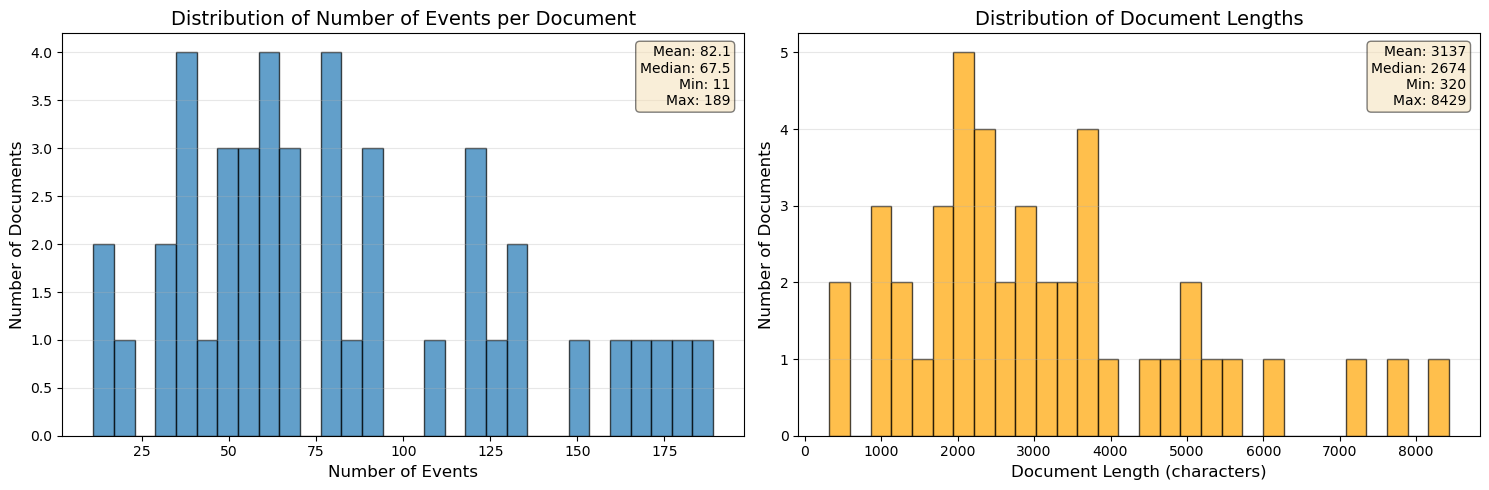


=== Statistics Summary ===

Number of Events per Document:
  Mean: 82.14
  Median: 68
  Std Dev: 46.83
  Min: 11
  Max: 189

Document Length (characters):
  Mean: 3137
  Median: 2674
  Std Dev: 1867
  Min: 320
  Max: 8429


In [54]:
# Visualize distributions
import matplotlib.pyplot as plt
import numpy as np

# Extract statistics
num_events_per_doc = [len(doc['events']) for doc in dataset]
doc_lengths = [len(doc['text']) for doc in dataset]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of number of events per document
axes[0].hist(num_events_per_doc, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Events', fontsize=12)
axes[0].set_ylabel('Number of Documents', fontsize=12)
axes[0].set_title('Distribution of Number of Events per Document', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)

# Add statistics text
mean_events = np.mean(num_events_per_doc)
median_events = np.median(num_events_per_doc)
min_events = np.min(num_events_per_doc)
max_events = np.max(num_events_per_doc)
axes[0].text(0.98, 0.97, f'Mean: {mean_events:.1f}\nMedian: {median_events:.1f}\nMin: {min_events}\nMax: {max_events}',
             transform=axes[0].transAxes, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Distribution of document lengths
axes[1].hist(doc_lengths, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Document Length (characters)', fontsize=12)
axes[1].set_ylabel('Number of Documents', fontsize=12)
axes[1].set_title('Distribution of Document Lengths', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

# Add statistics text
mean_length = np.mean(doc_lengths)
median_length = np.median(doc_lengths)
min_length = np.min(doc_lengths)
max_length = np.max(doc_lengths)
axes[1].text(0.98, 0.97, f'Mean: {mean_length:.0f}\nMedian: {median_length:.0f}\nMin: {min_length}\nMax: {max_length}',
             transform=axes[1].transAxes, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n=== Statistics Summary ===")
print(f"\nNumber of Events per Document:")
print(f"  Mean: {mean_events:.2f}")
print(f"  Median: {median_events:.0f}")
print(f"  Std Dev: {np.std(num_events_per_doc):.2f}")
print(f"  Min: {min_events}")
print(f"  Max: {max_events}")

print(f"\nDocument Length (characters):")
print(f"  Mean: {mean_length:.0f}")
print(f"  Median: {median_length:.0f}")
print(f"  Std Dev: {np.std(doc_lengths):.0f}")
print(f"  Min: {min_length}")
print(f"  Max: {max_length}")


In [55]:
# Get total number of documents and events
total_documents = len(dataset)
total_events = sum(len(doc['events']) for doc in dataset)

print(f"Total number of documents: {total_documents}")
print(f"Total number of events: {total_events}")
print(f"Average events per document: {total_events / total_documents:.2f}")


Total number of documents: 44
Total number of events: 3614
Average events per document: 82.14



=== Syntactic Distance Analysis ===
Events with closest timex: 3614
Events without timex: 0
Events using character distance (no syntactic path): 2428

Syntactic Distance Statistics:
  Mean: 6.32
  Median: 6
  Std Dev: 2.85
  Min: 1
  Max: 23


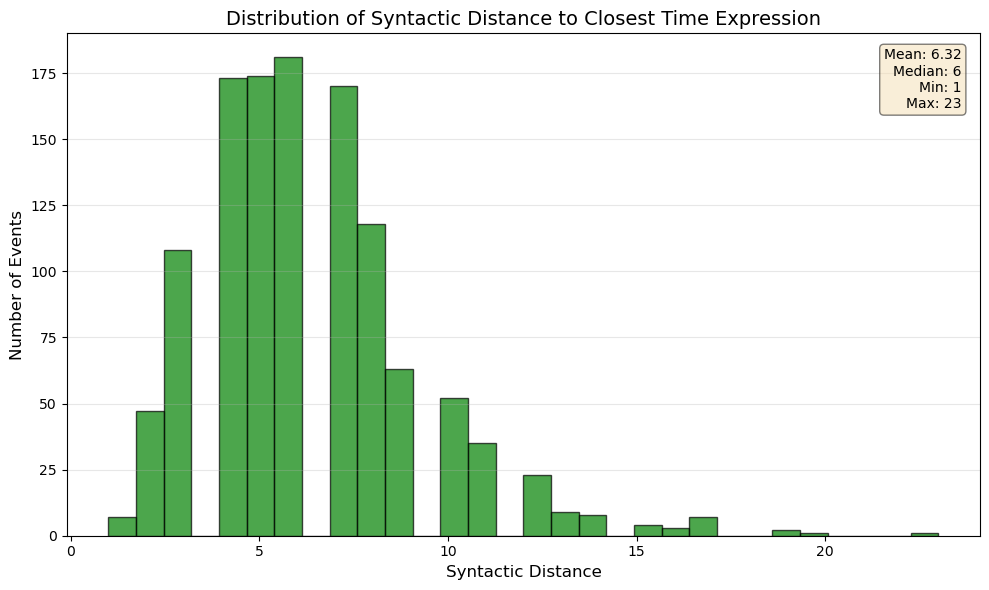


Character Distance Statistics (for events with no syntactic path):
  Mean: 243.00 characters
  Median: 167 characters
  Min: 3
  Max: 1345


In [56]:
# Analyze syntactic distance to closest timex
syntactic_distances = []
character_distances = []
events_with_timex = 0
events_without_timex = 0
events_using_char_distance = 0

for doc in dataset:
    for event in doc['events']:
        if event['closest_timex'] is not None:
            events_with_timex += 1
            if event['closest_timex']['syntactic_distance'] is not None:
                syntactic_distances.append(event['closest_timex']['syntactic_distance'])
            else:
                events_using_char_distance += 1
                if 'character_distance' in event['closest_timex']:
                    character_distances.append(event['closest_timex']['character_distance'])
        else:
            events_without_timex += 1

print(f"\n=== Syntactic Distance Analysis ===")
print(f"Events with closest timex: {events_with_timex}")
print(f"Events without timex: {events_without_timex}")
print(f"Events using character distance (no syntactic path): {events_using_char_distance}")

if syntactic_distances:
    print(f"\nSyntactic Distance Statistics:")
    print(f"  Mean: {np.mean(syntactic_distances):.2f}")
    print(f"  Median: {np.median(syntactic_distances):.0f}")
    print(f"  Std Dev: {np.std(syntactic_distances):.2f}")
    print(f"  Min: {np.min(syntactic_distances)}")
    print(f"  Max: {np.max(syntactic_distances)}")

    # Plot distribution of syntactic distances
    plt.figure(figsize=(10, 6))
    plt.hist(syntactic_distances, bins=30, edgecolor='black', alpha=0.7, color='green')
    plt.xlabel('Syntactic Distance', fontsize=12)
    plt.ylabel('Number of Events', fontsize=12)
    plt.title('Distribution of Syntactic Distance to Closest Time Expression', fontsize=14)
    plt.grid(axis='y', alpha=0.3)

    mean_dist = np.mean(syntactic_distances)
    median_dist = np.median(syntactic_distances)
    plt.text(0.98, 0.97, f'Mean: {mean_dist:.2f}\nMedian: {median_dist:.0f}\nMin: {np.min(syntactic_distances)}\nMax: {np.max(syntactic_distances)}',
             transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

if character_distances:
    print(f"\nCharacter Distance Statistics (for events with no syntactic path):")
    print(f"  Mean: {np.mean(character_distances):.2f} characters")
    print(f"  Median: {np.median(character_distances):.0f} characters")
    print(f"  Min: {np.min(character_distances)}")
    print(f"  Max: {np.max(character_distances)}")

In [57]:
# Show some examples of events with their closest timex
print("=== Examples of Events with Closest Time Expressions ===\n")
count = 0
for doc in dataset[:5]:  # First 5 documents
    print(f"Document: {doc['document_id']}")
    print(f"Timexs in document: {len(doc['timexs'])}")
    for event in doc['events'][:3]:  # First 3 events per document
        print(f"\n  Event: '{event['text']}' at position {event['location']}")
        if event['closest_timex']:
            timex = event['closest_timex']['timex']
            distance = event['closest_timex']['syntactic_distance']
            print(f"  Closest timex: {timex['val']} (type: {timex['type']}) at position {timex['start']}-{timex['end']}")
            print(f"  Syntactic distance: {distance}")
        else:
            print(f"  No timex found in document")
        count += 1
        if count >= 10:
            break
    if count >= 10:
        break
    print()


=== Examples of Events with Closest Time Expressions ===

Document: 101
Timexs in document: 11

  Event: 'An abdominal CAT scan' at position {'start': 4002, 'end': 4023}
  Closest timex: RPT12H (type: FREQUENCY) at position 5032-5038
  Syntactic distance: None

  Event: 'The abdominal CAT scan' at position {'start': 4753, 'end': 4775}
  Closest timex: RPT12H (type: FREQUENCY) at position 5032-5038
  Syntactic distance: None

  Event: 'sepsis' at position {'start': 3490, 'end': 3496}
  Closest timex: 1991-07-10 (type: DATE) at position 2306-2318
  Syntactic distance: None

Document: 108
Timexs in document: 13

  Event: 'states' at position {'start': 265, 'end': 271}
  Closest timex: P1W (type: DURATION) at position 316-322
  Syntactic distance: 5

  Event: 'chemotherapy' at position {'start': 294, 'end': 306}
  Closest timex: P1W (type: DURATION) at position 316-322
  Syntactic distance: 7

  Event: 'the floor' at position {'start': 2104, 'end': 2113}
  Closest timex: P8W (type: DURATIO

In [58]:
# Analyze accuracy of using closest timex for time prediction
from datetime import datetime, timedelta
import re

def parse_timex_value(val, timex_type):
    """Parse a timex value into minutes since 1900-01-01"""
    try:
        if timex_type == 'DATE':
            # Parse date format like '2012-06-08'
            dt = datetime.strptime(val, '%Y-%m-%d')
            return (dt - datetime(1900, 1, 1, 0, 0, 0, 0)).total_seconds() / 60
        elif timex_type == 'DURATION':
            # Duration cannot be used as absolute time
            return None
        else:
            # Try to parse as date-time
            try:
                dt = datetime.strptime(val, '%Y-%m-%d %H:%M')
                return (dt - datetime(1900, 1, 1, 0, 0, 0, 0)).total_seconds() / 60
            except:
                return None
    except:
        return None

# Analyze prediction accuracy
events_with_ground_truth = 0
events_with_closest_timex_and_ground_truth = 0
correct_predictions = 0
total_error_minutes = 0
errors_for_mean = []

# Define tolerance for "correct" prediction (in minutes)
tolerance_minutes = 60 * 24  # 1 day tolerance

detailed_results = []

for doc in dataset:
    for event in doc['events']:
        # Check if event has ground truth time
        if event['time'] and event['time'].get('start_time_minutes') is not None:
            events_with_ground_truth += 1
            ground_truth_start = event['time']['start_time_minutes']

            # Check if we have a closest timex
            if event['closest_timex'] is not None:
                timex = event['closest_timex']['timex']
                predicted_time = parse_timex_value(timex['val'], timex['type'])

                if predicted_time is not None:
                    events_with_closest_timex_and_ground_truth += 1

                    # Calculate error
                    error = abs(predicted_time - ground_truth_start)
                    total_error_minutes += error
                    errors_for_mean.append(error)

                    # Check if within tolerance
                    if error <= tolerance_minutes:
                        correct_predictions += 1

                    detailed_results.append({
                        'event_text': event['text'],
                        'event_id': event['event_id'],
                        'ground_truth': ground_truth_start,
                        'predicted': predicted_time,
                        'error_minutes': error,
                        'error_days': error / (60 * 24),
                        'timex_val': timex['val'],
                        'timex_type': timex['type'],
                        'syntactic_distance': event['closest_timex']['syntactic_distance']
                    })

print("\n" + "="*70)
print("=== TIME PREDICTION ACCURACY USING CLOSEST TIMEX ===")
print("="*70)
print(f"\nTotal events with ground truth time: {events_with_ground_truth}")
print(f"Events with both ground truth and usable closest timex: {events_with_closest_timex_and_ground_truth}")
print(f"\nEvents within {tolerance_minutes / (60 * 24):.0f} day(s) tolerance: {correct_predictions}")

if events_with_closest_timex_and_ground_truth > 0:
    accuracy = (correct_predictions / events_with_closest_timex_and_ground_truth) * 100
    print(f"Accuracy: {accuracy:.2f}%")

    mean_error_minutes = np.mean(errors_for_mean)
    median_error_minutes = np.median(errors_for_mean)
    mean_error_days = mean_error_minutes / (60 * 24)
    median_error_days = median_error_minutes / (60 * 24)

    print(f"\n=== Error Statistics ===")
    print(f"Mean absolute error: {mean_error_minutes:.2f} minutes ({mean_error_days:.2f} days)")
    print(f"Median absolute error: {median_error_minutes:.2f} minutes ({median_error_days:.2f} days)")
    print(f"Min error: {np.min(errors_for_mean):.2f} minutes ({np.min(errors_for_mean) / (60 * 24):.2f} days)")
    print(f"Max error: {np.max(errors_for_mean):.2f} minutes ({np.max(errors_for_mean) / (60 * 24):.2f} days)")
    print(f"Std dev: {np.std(errors_for_mean):.2f} minutes ({np.std(errors_for_mean) / (60 * 24):.2f} days)")



=== TIME PREDICTION ACCURACY USING CLOSEST TIMEX ===

Total events with ground truth time: 3577
Events with both ground truth and usable closest timex: 2160

Events within 1 day(s) tolerance: 1104
Accuracy: 51.11%

=== Error Statistics ===
Mean absolute error: 636303.41 minutes (441.88 days)
Median absolute error: 1110.00 minutes (0.77 days)
Min error: 60.00 minutes (0.04 days)
Max error: 41572170.00 minutes (28869.56 days)
Std dev: 3205772.99 minutes (2226.23 days)


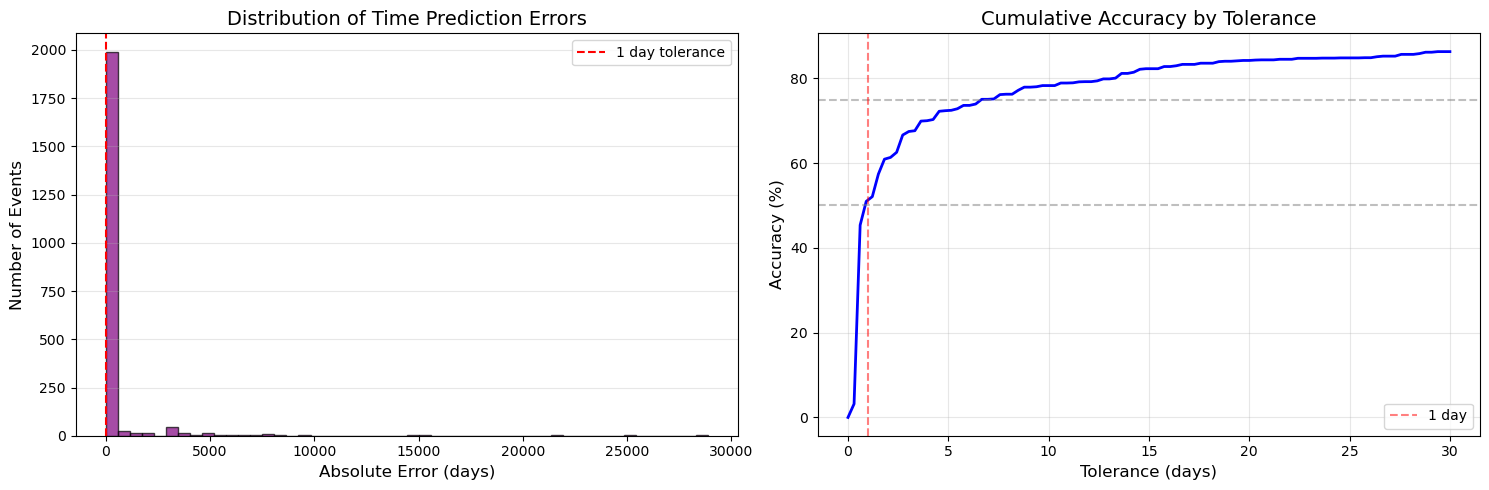

In [59]:
# Visualize error distribution
if len(errors_for_mean) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Error distribution in days
    errors_in_days = [e / (60 * 24) for e in errors_for_mean]
    axes[0].hist(errors_in_days, bins=50, edgecolor='black', alpha=0.7, color='purple')
    axes[0].set_xlabel('Absolute Error (days)', fontsize=12)
    axes[0].set_ylabel('Number of Events', fontsize=12)
    axes[0].set_title('Distribution of Time Prediction Errors', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].axvline(x=1, color='red', linestyle='--', label='1 day tolerance')
    axes[0].legend()

    # Plot 2: Cumulative accuracy by tolerance
    tolerances = np.linspace(0, 30, 100)  # 0 to 30 days
    cumulative_accuracy = []
    for tol in tolerances:
        count = sum(1 for e in errors_in_days if e <= tol)
        cumulative_accuracy.append((count / len(errors_in_days)) * 100)

    axes[1].plot(tolerances, cumulative_accuracy, linewidth=2, color='blue')
    axes[1].set_xlabel('Tolerance (days)', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Cumulative Accuracy by Tolerance', fontsize=14)
    axes[1].grid(alpha=0.3)
    axes[1].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    axes[1].axhline(y=75, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(x=1, color='red', linestyle='--', alpha=0.5, label='1 day')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [60]:
# Show best and worst predictions
print("\n=== Best Predictions (smallest errors) ===")
sorted_results = sorted(detailed_results, key=lambda x: x['error_minutes'])
for i, result in enumerate(sorted_results[:10]):
    print(f"\n{i+1}. Event: '{result['event_text']}'")
    print(f"   Predicted timex: {result['timex_val']} (distance: {result['syntactic_distance']})")
    print(f"   Error: {result['error_days']:.2f} days")

print("\n\n=== Worst Predictions (largest errors) ===")
for i, result in enumerate(sorted_results[-10:]):
    print(f"\n{i+1}. Event: '{result['event_text']}'")
    print(f"   Predicted timex: {result['timex_val']} (distance: {result['syntactic_distance']})")
    print(f"   Error: {result['error_days']:.2f} days")



=== Best Predictions (smallest errors) ===

1. Event: 'left sided abdominal pain'
   Predicted timex: 2018-08-04 (distance: 11)
   Error: 0.04 days

2. Event: 'abdominal pain'
   Predicted timex: 2018-08-04 (distance: 11)
   Error: 0.04 days

3. Event: 'mild hydronephrosis'
   Predicted timex: 2018-08-04 (distance: None)
   Error: 0.04 days

4. Event: 'new perinephric fluid'
   Predicted timex: 2018-08-04 (distance: None)
   Error: 0.04 days

5. Event: 'retroperitoneal hemorrhage'
   Predicted timex: 2018-08-04 (distance: None)
   Error: 0.04 days

6. Event: 'sudden onset left-sided abdominal pain'
   Predicted timex: 2018-08-04 (distance: 11)
   Error: 0.04 days

7. Event: 'the Medical Intensive Care Unit'
   Predicted timex: 2011-03-11 (distance: None)
   Error: 0.12 days

8. Event: 'overnight observation'
   Predicted timex: 2011-03-11 (distance: None)
   Error: 0.12 days

9. Event: 'her somnolence'
   Predicted timex: 2011-03-11 (distance: None)
   Error: 0.12 days

10. Event: 'pl

In [61]:
# Analyze correlation between syntactic distance and prediction error
if len(detailed_results) > 0:
    syntactic_dists = [r['syntactic_distance'] for r in detailed_results]
    pred_errors = [r['error_days'] for r in detailed_results]

    # Calculate correlation
    correlation = np.corrcoef(syntactic_dists, pred_errors)[0, 1]

    print(f"\n=== Correlation Analysis ===")
    print(f"Correlation between syntactic distance and prediction error: {correlation:.3f}")

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(syntactic_dists, pred_errors, alpha=0.3, s=20)
    plt.xlabel('Syntactic Distance', fontsize=12)
    plt.ylabel('Prediction Error (days)', fontsize=12)
    plt.title(f'Syntactic Distance vs Prediction Error (correlation: {correlation:.3f})', fontsize=14)
    plt.grid(alpha=0.3)

    # Add trend line
    z = np.polyfit(syntactic_dists, pred_errors, 1)
    p = np.poly1d(z)
    plt.plot(sorted(syntactic_dists), p(sorted(syntactic_dists)),
             "r--", alpha=0.8, linewidth=2, label='Trend line')
    plt.legend()

    plt.tight_layout()
    plt.show()


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [62]:
# Find examples where closest timex is within 1 day but has no syntactic dependency
print("="*80)
print("=== Examples: Accurate Predictions WITHOUT Syntactic Dependency ===")
print("="*80)
print("\nShowing cases where:")
print("- Prediction error <= 1 day")
print("- No syntactic path exists (using character distance)")
print()

examples_found = 0
max_examples = 3

for doc in dataset:
    if examples_found >= max_examples:
        break

    for event in doc['events']:
        if examples_found >= max_examples:
            break

        # Check if event has ground truth and closest timex
        if (event['time'] and
            event['time'].get('start_time_minutes') is not None and
            event['closest_timex'] is not None):

            # Check if using character distance (no syntactic path)
            if event['closest_timex']['syntactic_distance'] is None:
                timex = event['closest_timex']['timex']
                predicted_time = parse_timex_value(timex['val'], timex['type'])

                if predicted_time is not None:
                    ground_truth = event['time']['start_time_minutes']
                    error_minutes = abs(predicted_time - ground_truth)
                    error_days = error_minutes / (60 * 24)

                    # Check if within 1 day
                    if error_days <= 1.0:
                        examples_found += 1

                        # Get the document text
                        text = doc['text']
                        event_start = event['location']['start']
                        event_end = event['location']['end']
                        timex_start = timex['start']
                        timex_end = timex['end']

                        print(f"\n{'='*80}")
                        print(f"EXAMPLE {examples_found}")
                        print(f"{'='*80}")
                        print(f"Document ID: {doc['document_id']}")
                        print(f"Error: {error_days:.2f} days")
                        print(f"Character distance: {event['closest_timex'].get('character_distance', 'N/A')} characters")
                        print()

                        # Create annotated text showing event and timex positions
                        # Sort by position to handle them in order
                        annotations = []
                        annotations.append(('EVENT', event_start, event_end, event['text']))
                        annotations.append(('TIMEX', timex_start, timex_end, timex['val']))
                        annotations.sort(key=lambda x: x[1])

                        # Build annotated text
                        print("TEXT WITH ANNOTATIONS:")
                        print("-" * 80)

                        last_pos = 0
                        annotated_parts = []

                        for ann_type, start, end, value in annotations:
                            # Add text before annotation
                            if start > last_pos:
                                annotated_parts.append(text[last_pos:start])

                            # Add annotated part
                            if ann_type == 'EVENT':
                                annotated_parts.append(f"**[EVENT: {text[start:end]}]**")
                            else:
                                annotated_parts.append(f"<<[TIMEX: {text[start:end]}]>>")

                            last_pos = end

                        # Add remaining text
                        if last_pos < len(text):
                            annotated_parts.append(text[last_pos:])

                        annotated_text = ''.join(annotated_parts)

                        # Print with wrapping
                        import textwrap
                        wrapped = textwrap.fill(annotated_text, width=78)
                        print(wrapped)

                        print()
                        print(f"Event: '{event['text']}'")
                        print(f"Closest Timex: '{text[timex_start:timex_end]}' (value: {timex['val']}, type: {timex['type']})")
                        print(f"Ground Truth Time: {ground_truth:.0f} minutes")
                        print(f"Predicted Time: {predicted_time:.0f} minutes")
                        print(f"Prediction Error: {error_days:.4f} days ({error_minutes:.0f} minutes)")

if examples_found == 0:
    print("\nNo examples found matching the criteria.")
else:
    print(f"\n{'='*80}")
    print(f"Found {examples_found} example(s)")
    print(f"{'='*80}")


=== Examples: Accurate Predictions WITHOUT Syntactic Dependency ===

Showing cases where:
- Prediction error <= 1 day
- No syntactic path exists (using character distance)


EXAMPLE 1
Document ID: 101
Error: 0.52 days
Character distance: 1172 characters

TEXT WITH ANNOTATIONS:
--------------------------------------------------------------------------------
 Admission Date : 07/10/1991 Discharge Date : 07/18/1991 PROCEDURES :
Thoracentesis was performed on 7-12-91 . REASON FOR ADMISSION : The patient is
an 85-year-old white male with a history of ischemic bowel status post recent
admission for urosepsis and C. difficile colitis . He returns from the nursing
home with fever , leukocytosis , and azotemia . PRESENT ILLNESS : Briefly ,
the patient has a history of chronic obstructive pulmonary disease , ethanol
abuse , chronic pleural effusions , and chronic renal insufficiency . He
presented to Gaanvantsir on 04-17-92 with abdominal pain and bloody diarrhea .
Workup revealed ischemic bowel

In [63]:
# Calculate percentage of events within 1 day of DATE-type timex with syntactic connection
print("\n" + "="*80)
print("=== Analysis: Events Within 1 Day of Syntactically Connected DATE Timex ===")
print("="*80)
print("\nCriteria:")
print("- Closest timex is of type DATE")
print("- Has syntactic connection (syntactic_distance is not None)")
print("- Prediction error <= 1 day")
print()

total_events_in_dataset = 0
matching_events = 0

for doc in dataset:
    for event in doc['events']:
        total_events_in_dataset += 1

        # Check if event has ground truth time and closest timex
        if (event['time'] and
            event['time'].get('start_time_minutes') is not None and
            event['closest_timex'] is not None):

            timex = event['closest_timex']['timex']

            # Check if timex is of type DATE
            if timex['type'] == 'DATE':

                # Check if there's a syntactic connection (not using character distance fallback)
                if event['closest_timex']['syntactic_distance'] is not None:

                    # Parse and check if within 1 day
                    predicted_time = parse_timex_value(timex['val'], timex['type'])

                    if predicted_time is not None:
                        ground_truth = event['time']['start_time_minutes']
                        error_minutes = abs(predicted_time - ground_truth)
                        error_days = error_minutes / (60 * 24)

                        if error_days <= 1.0:
                            matching_events += 1

percentage = (matching_events / total_events_in_dataset) * 100 if total_events_in_dataset > 0 else 0

print(f"Total events in dataset: {total_events_in_dataset}")
print(f"Events meeting all criteria: {matching_events}")
print(f"\nPercentage: {percentage:.2f}%")
print(f"({matching_events} / {total_events_in_dataset})")



=== Analysis: Events Within 1 Day of Syntactically Connected DATE Timex ===

Criteria:
- Closest timex is of type DATE
- Has syntactic connection (syntactic_distance is not None)
- Prediction error <= 1 day

Total events in dataset: 3614
Events meeting all criteria: 465

Percentage: 12.87%
(465 / 3614)
